In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
import pyBigWig
import seaborn as sns
import pickle
import pyranges as pr
from statistics import mode
import matplotlib
import pyBigWig
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from scipy.sparse import csr_matrix
%matplotlib inline

In [2]:
def get_bias_single_seq(seq, bias_model, seq_len_threshold=5):
    '''
    Compute the sequence bias for a given sequence
    :param seq: String. Sequence context
    :param bias_model. We will retrieve bias using bias_model["forward"][seq_context] or bias_model["reverse"][seq_context]
    :param seq_len_threshold: Positions at the edge of the locus will have a shorter context (we don't do padding).
        For these edge positions we set a super high bias to prevent false positive footprints.
    :return: List of [C-to-T bias,  G-to-A bias]
    '''
    
    # If the sequence is too short, return a high bias
    if len(seq) < seq_len_threshold:
        return [100, 100]

    # Extract the center base being edited
    seq_radius = int((len(seq) - 1) / 2)
    center_base = seq[seq_radius]

    # A and T can't be edited so they have a bias of 0
    if center_base in ["A", "T", "N"] or "N" in seq:
        return [0, 0]

    elif center_base == "C":
        return [bias_model["forward"][seq], 0]

    elif center_base == "G":
        return [0, bias_model["reverse"][seq]]

def get_aggregate_footprints(
        binding_sites, chr_sizes, bw_edit, 
        bw_coverage, genome_seq, bias_model,
        bias_radius=1, # Radius for calculating DddA sequence bias
        window_radius=1000):
    '''
    Compute aggregate footprints for a specific TF.
    
    '''
    
    # Calculate aggreagte bias and edits
    agg_edits, agg_bias = 0, 0
    for i, row in tqdm(binding_sites.iterrows()):
    
        # Get the genomic window surrounding the motif site
        chr, start, end, name, score, strand = row
        motif_center = int((start + end) / 2)
        start, end = motif_center - window_radius, motif_center + window_radius
        if start < 0 or end > chr_sizes.loc[chr]["size"]:
            continue
    
        # Extract DddA edits and coverage at cytosine bases
        region_edits = np.array(bw_edit.values(chr, start, end))
        region_edits[np.isnan(region_edits)] = 0
        region_coverage = np.array(bw_coverage.values(chr, start, end))
        region_coverage[np.isnan(region_coverage)] = 0
    
        # Calculate DddA bias for each base-pair (adjusted by coverage)
        region_seq = genome_seq[chr][start:end].upper()
        len_seq = len(region_seq)
        context = [region_seq[max(0, i - bias_radius):min(len_seq, i + bias_radius + 1)] for i in range(len_seq)]
        bias = np.array([get_bias_single_seq(c, bias_model, 2 * bias_radius + 1) for c in context])
        bias = np.array([np.multiply(bias[:, i], region_coverage) for i in range(2)]).T
        bias = np.sum(bias, axis=1) # Combine forward and reverse strand bias

        # Mask CpG positions
        context = [region_seq[max(0, i - 1):min(len_seq, i + 2)] for i in range(len_seq)] 
        CpG_mask = np.array([i for i in range(len(context))\
            if context[i][:2] == "CG" or context[i][1:] == "CG"])
        if len(CpG_mask) > 0:
            bias[CpG_mask] = 0
            region_edits[CpG_mask] = 0
    
        # Flip the data if the motif is on the reverse strand
        if strand == "-":
            region_edits = np.flip(region_edits)
            region_coverage = np.flip(region_coverage)
            bias = np.flip(bias)
    
        # Mask edits at positions with zero bias (which are positions of A, T and positions with Ns in local context)
        region_edits = np.multiply(region_edits, bias > 0)
    
        agg_edits += region_edits
        agg_bias += bias
    
    # Calculate aggregate footprint scores
    footprint_scores = []
    for r in range(1, 100):
        footprint_pvals = get_footprint_single_scale(
            edits = agg_edits, 
            bias = agg_bias, 
            fp_radius=r, 
            combine_sides="max_pval",
            pseudo_count_factor=0.01
        ) + 1e-300
        footprint_scores.append(-np.log10(footprint_pvals))
    footprint_scores = np.flip(np.array(footprint_scores), axis=0)

    return footprint_scores

def get_aggreagte_bw(
        binding_sites, chr_sizes, bw,
        window_radius=1000):
    
    agg_signal = 0
    for i, row in tqdm(binding_sites.iterrows()):
    
        # Get the genomic window surrounding the motif site
        chr, start, end, name, score, strand = row
        motif_center = int((start + end) / 2)
        start, end = motif_center - window_radius, motif_center + window_radius
        if start < 0 or end >= chr_sizes.loc[chr]["size"]:
            continue
    
        # Extract DddA edits and coverage at cytosine bases
        region_signal = np.array(bw.values(chr, start, end))
        region_signal[np.isnan(region_signal)] = 0
        agg_signal += region_signal
    agg_signal = agg_signal / binding_sites.shape[0]
    return agg_signal

In [3]:
# Create a folder to save plots
working_dir = "/home/yanhu/data/DddA/HJR253/"
plot_dir = os.path.join("/home/yanhu/data/DddA/HJR253/", "plot")
os.system("mkdir -p " + plot_dir)

# Load genomic sequences
genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa"
genome_seq = {}
for record in SeqIO.parse(genome_file, "fasta"):
    genome_seq[record.id] = record.seq

# Load DddA sequence bias model
bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
with open(bias_model_path, "rb") as f:
    bias_model = pickle.load(f)

# Load chromosome sizes
chr_size_path = "/home/yanhu/data/DddA/shared/hg38.chrom.sizes"
chr_sizes = pd.read_table(chr_size_path, header=None)
chr_sizes.columns = columns=["chr", "size"]
chr_sizes.index = chr_sizes["chr"]

# Load bigwig files of DddA edits and coverage
bw_edit_path = os.path.join(working_dir, "HJR253_4_edit.bw")
bw_edit = pyBigWig.open(bw_edit_path)
bw_coverage_path = os.path.join(working_dir, "HJR253_4_coverage.bw")
bw_coverage = pyBigWig.open(bw_coverage_path)

# Load bigwig file of DNase edits
bw_DNase_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/DNaseIFootprint/vierstra/"
bw_DNase_path = os.path.join(bw_DNase_dir, "interval.all.winlnpval.K562-DS15363.bw")
bw_DNase = pyBigWig.open(bw_DNase_path)

### Calculate aggregate edits and bias around TF motif sites

ATF2


2000it [00:57, 35.02it/s]
2000it [00:01, 1907.47it/s]


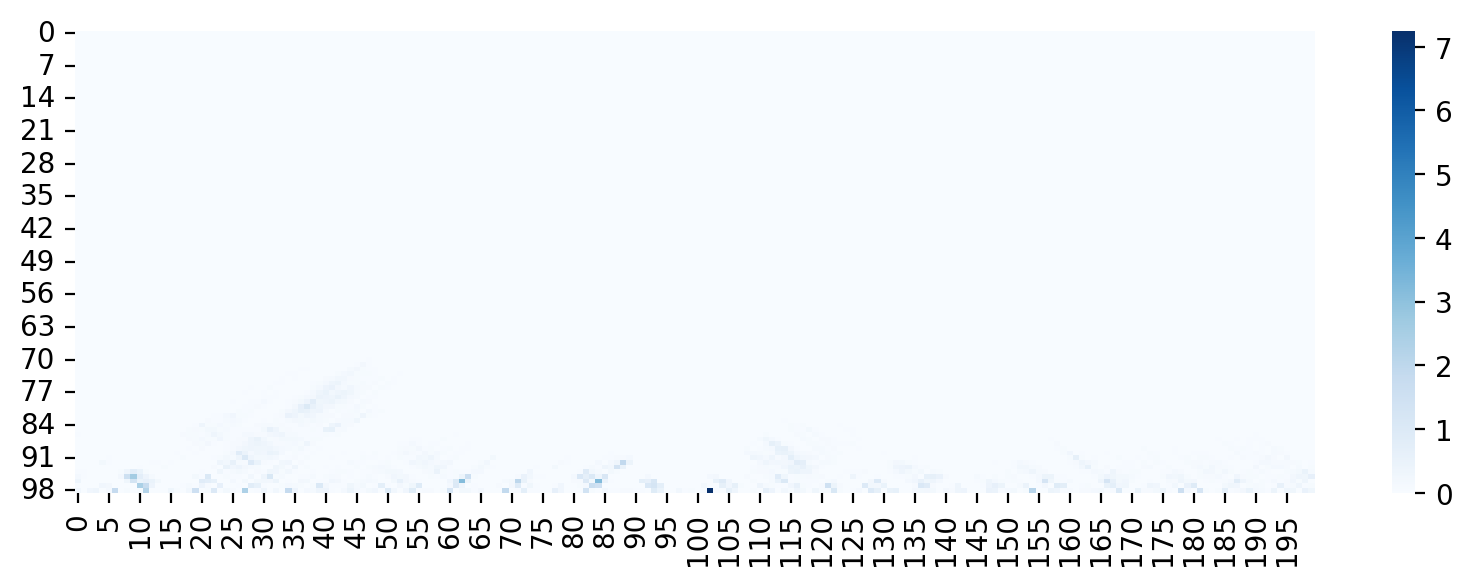

ATF3
ATF4


602it [00:17, 30.06it/s]

In [ ]:
# Create folders for saving visaulization results
multi_scale_plot_dir = "/home/yanhu/data/DddA/HJR253/plot/multiscale"
os.makedirs(multi_scale_plot_dir, exist_ok=True)

# Retrieve the full list of TFs with Unibind data in the selected cell type
cell_type = "K562"
unibind_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/shared/unibind/damo_hg38_all_TFBS"
unibind_subdirs = os.listdir(unibind_dir)
TFs = [re.split("\\.", subdir)[-1] for subdir in unibind_subdirs if cell_type in subdir]
TFs = np.unique(TFs)

# Visualize aggregate footprints
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#FFFFFF"],
          [norm( 1.0), "#0D7D87"]]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

comparison = []
for TF in TFs:
    
    print(TF)
    
    # Load Unibind binding sites of the current TF
    kept_subdir = [d for d in unibind_subdirs if TF in d and cell_type in d]
    binding_sites = None
    for subdir in kept_subdir:
        file = os.listdir(os.path.join(unibind_dir, subdir))[0]
        new_binding_sites = pr.read_bed(os.path.join(unibind_dir, subdir, file))
        if binding_sites is None:
            binding_sites = new_binding_sites
        else:
            binding_sites = binding_sites.intersect(new_binding_sites)
    motif_width = binding_sites.End - binding_sites.Start
    binding_sites = binding_sites[motif_width == mode(motif_width)].df

    # Only keep autosomes and X, Y chromosomes
    kept_chrs = ["chr" + str(i + 1) for i in np.arange(22)] + ["chrX", "chrY"]
    filter = np.array([True if chr in kept_chrs else False for chr in binding_sites["Chromosome"]])
    binding_sites = binding_sites.loc[filter, :]
    
    # Down-sample the site to a fixed number
    site_inds = np.arange(binding_sites.shape[0])
    if len(site_inds) < 2000:
        continue
    binding_sites = binding_sites.iloc[np.random.choice(site_inds, 2000, replace=False)]
    
    # Calculate aggregate footprint scores
    footprint_scores = get_aggregate_footprints(
            binding_sites, chr_sizes, bw_edit, 
            bw_coverage, genome_seq, bias_model)
    
    # Calculate aggregate DNase footprint scores
    agg_DNase = get_aggreagte_bw(binding_sites, chr_sizes, bw_DNase)
    
    # Record the max footprint score at the motif center
    comparison.append([TF, np.max(footprint_scores[:, 990:1010]), 
                       np.max(agg_DNase[990:1010])])
    
    # Visualize aggregate footprints
    plt.figure(dpi=200, figsize=(10,3))
    sns.heatmap(footprint_scores[:, 900:1100], cmap=cmap)
    plt.savefig(os.path.join(multi_scale_plot_dir, TF + "_agg_multi_scale.png"))
    plt.show()

In [204]:
comparison = pd.DataFrame(comparison, columns=["TF", "DddA_footprint", "DNase_footprint"])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


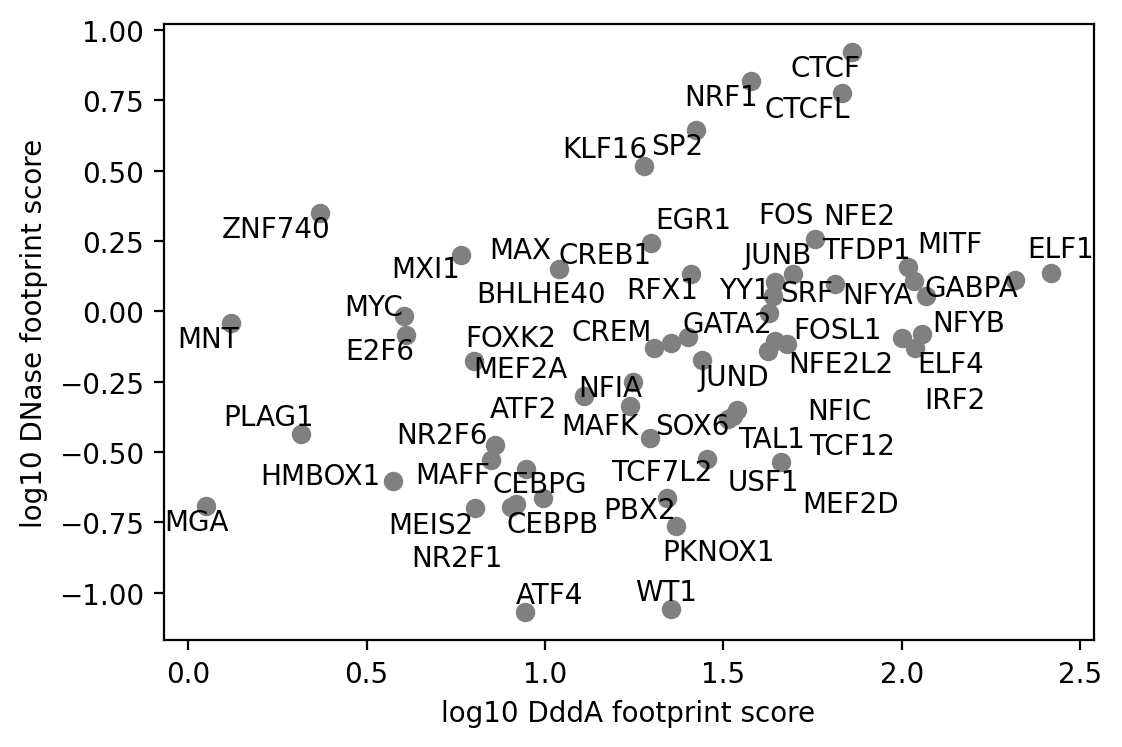

In [229]:
from adjustText import adjust_text
plt.figure(dpi=200, figsize=(6,4))
x = np.log10(comparison["DddA_footprint"].values)
y = np.log10(comparison["DNase_footprint"].values)
plt.scatter(x, y, color="grey")
texts = [plt.text(x[i], y[i], comparison["TF"].values[i], ha='center', va='center') \
         for i in range(comparison.shape[0])]
plt.xlabel("log10 DddA footprint score")
plt.ylabel("log10 DNase footprint score")
adjust_text(texts)
plt.savefig("/home/yanhu/data/DddA/HJR253/plot/DNase_DddA_footprint_comparison_logscale.pdf")
plt.show()